In [1]:
# GPU 구동 확인
from tensorflow.python.client import device_lib

device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 7840329480095085399,
 name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 4965466112
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 7193025759096155053
 physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"]

In [2]:
import sys, os

LOCAL_PACKAGE_DIR = os.path.abspath("./keras-yolo3")
sys.path.append(LOCAL_PACKAGE_DIR)

from yolo3.model import preprocess_true_boxes, yolo_body, tiny_yolo_body, yolo_loss
from yolo3.utils import get_random_data

from yolo import YOLO, detect_video
#keras-yolo에서 image처리를 주요 PIL로 수행.
import argparse
import time
from PIL import Image
from keras.models import load_model
import pandas as pd
import numpy as np
from PIL import Image
import cv2
import matplotlib.pyplot as plt
%matplotlib inline

Using TensorFlow backend.


In [3]:
'''
(1) 개 탐지 YOLO 모델
(2) 개 얼굴 탐지 YOLO 모델
(3) 개 품종 분류 CNN 모델
(4) 입마개 착용 여부 분류 CNN 모델
'''

dog_yolo = YOLO(model_path='C:/Users/Beomhui/Desktop/캡스톤 디자인/Dog detector.h5',
                anchors_path='~/Desktop/캡스톤 디자인/keras-yolo3/model_data/yolo_anchors.txt',
                classes_path='~/Desktop/캡스톤 디자인/keras-yolo3/model_data/Dog_classes.txt')

dog_face_yolo = YOLO(model_path='C:/Users/Beomhui/Desktop/캡스톤 디자인/Dog_face detector.h5',
                     anchors_path='~/Desktop/캡스톤 디자인/keras-yolo3/model_data/yolo_anchors.txt',
                     classes_path='~/Desktop/캡스톤 디자인/keras-yolo3/model_data/Dog_face_classes.txt')

dog_breed_cnn = load_model('./dog breed classifier.h5')

dog_muzzle_cnn = load_model('./dog muzzle classifier.h5')

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
C:/Users/Beomhui/Desktop/캡스톤 디자인/Dog detector.h5 model, anchors, and classes loaded.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
C:/Users/Beomhui/Desktop/캡스톤 디자인/Dog_face detector.h5 model, anchors, and classes loaded.





In [4]:
# 개 품종과 입마개 착용 여부 레이블.

breed_label = pd.read_csv('encoding_label.csv').drop('Unnamed: 0', axis=1)
muzzle_label = pd.DataFrame({'Muzzle' : ['Yes', 'No']})

In [5]:
# 개 품종 분류와 입마개 착용 여부 분류를 위해 이미지 크기 변환

def transfer_image(img):
    resize = img.resize((224, 224))
    resize = np.array(resize)/255.
    resize = resize.reshape(1, 224, 224, 3)
    return resize

In [6]:
# 개 품종 레이블 반환

def get_pred_breed_label(pred_prob):
    return breed_label.iloc[np.argmax(pred_prob)]['breed']

In [7]:
# 입마개 착용 여부 레이블 반환

def get_pred_muzzle_label(pred_prob):
    if pred_prob > 0.5:
        return 'Without muzzle'
    else:
        return 'With Muzzle'

In [8]:
# 개 품종 분류 결과 시각화

def plot_pred(pred_prob, pred_label, img):
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    
    plt.title("{} {:2.0f}%".format(pred_label, np.max(pred_prob)*100))

def dog_plot_pred_conf(pred_prob, pred_label):
    top_10_pred_indexes = pred_prob.argsort()[0, -10:][::-1] # argsort 작은값부터 순서대로
    top_10_pred_values = pred_prob[0, top_10_pred_indexes]
    top_10_pred_labels = breed_label.iloc[top_10_pred_indexes]['breed']
    
    top_plot = plt.bar(np.arange(len(top_10_pred_labels)), 
                       top_10_pred_values, 
                       color="grey")
    plt.xticks(np.arange(len(top_10_pred_labels)),
               labels=top_10_pred_labels,
               rotation="vertical")
    
    if True:
        top_plot[np.argmax(pred_label)].set_color("green")

In [9]:
# 입마개 착용 여부 분류 결과 시각화
        
def muzzle_plot_pred_conf(pred_prob, pred_label):
    pred_indexes = ['With muzzle', 'Without muzzle']
    pred_values = [1-float(pred_prob.reshape(-1)), float(pred_prob.reshape(-1))]
    pred_labels = 2
    
    top_plot = plt.bar(np.arange(pred_labels), 
                       pred_values, 
                       color="grey")
    plt.xticks(np.arange(pred_labels),
               labels=pred_indexes,
               rotation="vertical")
    
    if True:
        top_plot[np.argmax(pred_values)].set_color("green")

In [10]:
# 개 이미지에서 개 얼굴을 제대로 탐지하지 못할 경우 예외처리가 필요

def detect_image(dog_yolo, dog_face_yolo, dog_breed_cnn, dog_muzzle_cnn, img):
    green_color = (0, 255, 0)
    blue_color = (255, 0, 0)
    
    dog_image, dog_info = dog_yolo.detect_image(img)
    dog_image_array = np.array(dog_image)
    dog_row = dog_image_array.shape[0]
    dog_col = dog_image_array.shape[1]

    tmp = []
    for data in dog_info:
        label = data[0]
        dog_left_top = data[1]
        dog_right_bottom = data[2]

        dog_obj = Image.fromarray(dog_image_array[dog_left_top[1]:dog_right_bottom[1]+1, dog_left_top[0]:dog_right_bottom[0]+1, :])
        dog_resize = transfer_image(dog_obj)

        breed_pred_prob = dog_breed_cnn.predict(dog_resize)
        breed_pred_label = get_pred_breed_label(breed_pred_prob)
        
        plt.subplot(1, 2, 1)
        plot_pred(breed_pred_prob, breed_pred_label, dog_obj)
        plt.subplot(1, 2, 2)
        dog_plot_pred_conf(breed_pred_prob, breed_pred_label)
        #plt.savefig('C:/Users/Beomhui/Desktop/캡스톤 디자인/Dog image/dog.jpg')
        plt.close()
    
        # 조건문을 이용하여 탐지된 개가 맹견일 경우, 개 얼굴 탐지와 입마개 착용 분류를 진행

        dog_face_image, dog_face_info = dog_face_yolo.detect_image(dog_obj)
        dog_face_image_array = np.array(dog_face_image)

        for data in dog_face_info:
            label = data[0]
            muzzle_left_top = data[1]
            muzzle_right_bottom = data[2]

            dog_face_obj = Image.fromarray(dog_face_image_array[muzzle_left_top[1]:muzzle_right_bottom[1]+1, muzzle_left_top[0]:muzzle_right_bottom[0]+1, :])
            dog_face_resize = transfer_image(dog_face_obj)

            muzzle_pred_prob = dog_muzzle_cnn.predict(dog_face_resize)
            muzzle_pred_label = get_pred_muzzle_label(muzzle_pred_prob)
            
            plt.subplot(1, 2, 1)
            plot_pred(muzzle_pred_prob, muzzle_pred_label, dog_face_obj)
            plt.subplot(1, 2, 2)
            muzzle_plot_pred_conf(muzzle_pred_prob, muzzle_pred_label)
            #plt.savefig('C:/Users/Beomhui/Desktop/캡스톤 디자인/Dog image/dog.jpg')
            plt.close()
    
            tmp_left_top = ((dog_left_top[0] + muzzle_left_top[0]), (dog_left_top[1] + muzzle_left_top[1]))
            tmp_right_bottom = ((dog_left_top[0] + muzzle_right_bottom[0]), (dog_left_top[1] + muzzle_right_bottom[1]))
            tmp.append((muzzle_pred_label, muzzle_pred_prob, tmp_left_top, tmp_right_bottom))

    numpy_img = np.array(dog_image)
    opencv_img = cv2.cvtColor(numpy_img, cv2.COLOR_BGR2RGB)
    
    for info in tmp:
        label = info[0]
        prob = info[1]
        left_top = info[2]
        right_bottom = info[3]

        if label == 'Without muzzle':
            caption = '{} : {:.2f}'.format(label, prob.reshape(-1)[0])
            opencv_img = cv2.rectangle(opencv_img, left_top, right_bottom, green_color, 2)
            opencv_img = cv2.putText(opencv_img, caption, (left_top[0], left_top[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, green_color, 1)
        else:
            caption = '{} : {:.2f}'.format(label, 1-prob.reshape(-1)[0])
            opencv_img = cv2.rectangle(opencv_img, left_top, right_bottom, blue_color, 2)
            opencv_img = cv2.putText(opencv_img, caption, (left_top[0], left_top[1] - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, blue_color, 1)

    color_coverted = cv2.cvtColor(opencv_img, cv2.COLOR_BGR2RGB)
    pil_image=Image.fromarray(color_coverted)
    #plt.savefig('C:/Users/Beomhui/Desktop/캡스톤 디자인/Result/dog.jpg')
    plt.close()

    return pil_image

In [11]:
def detect_video(input_path, output_path=""):
    
    start = time.time()
    cap = cv2.VideoCapture(input_path)
    
#     codec = cv2.VideoWriter_fourcc(*'DIVX')
    codec = cv2.VideoWriter_fourcc(*'XVID')
    vid_fps = cap.get(cv2.CAP_PROP_FPS)
    vid_size = (int(cap.get(cv2.CAP_PROP_FRAME_WIDTH)),int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    vid_writer = cv2.VideoWriter(output_path, codec, vid_fps, vid_size)
    
    frame_cnt = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    print('총 Frame 갯수:', frame_cnt, '원본 영상 FPS:',vid_fps, '원본 Frame 크기:', vid_size)
    index = 0
    while True:
        hasFrame, image_frame = cap.read()
        if not hasFrame:
            print('프레임이 없거나 종료 되었습니다.')
            break
        start = time.time()
        # PIL Package를 내부에서 사용하므로 cv2에서 읽은 image_frame array를 다시 PIL의 Image형태로 변환해야 함.  
        image = Image.fromarray(image_frame)
        # 아래는 인자로 입력된 yolo객체의 detect_image()로 변환한다.
        detected_image  = detect_image(dog_yolo, dog_face_yolo, dog_breed_cnn, dog_muzzle_cnn, image)
        # cv2의 video writer로 출력하기 위해 다시 PIL의 Image형태를 array형태로 변환 
        result = np.asarray(detected_image)
        index +=1
        print('#### frame:{0} 이미지 처리시간:{1}'.format(index, round(time.time()-start,3)))
        vid_writer.write(result)
    
    vid_writer.release()
    cap.release()
    print('### Video Detect 총 수행시간:', round(time.time()-start, 5))

In [12]:
def detect_webcam(): 
    cap = cv2.VideoCapture(0)
#    cap = cv2.VideoCapture("http://192.168.137.175:8091/?action=stream")
    while True:
        _, image_frame = cap.read()

        # PIL Package를 내부에서 사용하므로 cv2에서 읽은 image_frame array를 다시 PIL의 Image형태로 변환해야 함.  
        image = Image.fromarray(image_frame)
        # 아래는 인자로 입력된 yolo객체의 detect_image()로 변환한다.
        detected_image  = detect_image(dog_yolo, dog_face_yolo, dog_breed_cnn, dog_muzzle_cnn, image)
        #detected_image = detected_image.resize((832, 832))
        # cv2의 video writer로 출력하기 위해 다시 PIL의 Image형태를 array형태로 변환 
        result = np.asarray(detected_image)
        
        cv2.imshow('Image', result)
        
        key = cv2.waitKey(1)
        if key == ord('q'):
            cv2.destroyAllWindows()
            break
        
    cap.release()

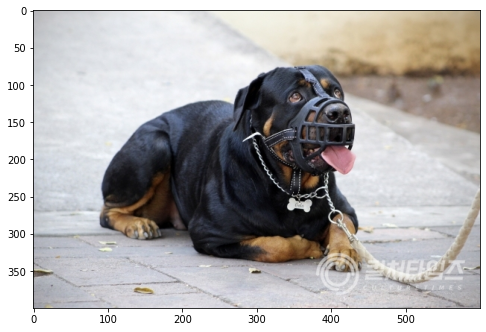

In [13]:
img = Image.open('C:/Users/Beomhui/Desktop/캡스톤 디자인/5.jpg')
plt.figure(figsize=(8, 8))
plt.imshow(img)

In [ ]:
# 이미지 속 객체 탐지
detected_image = detect_image(dog_yolo, dog_face_yolo, dog_breed_cnn, dog_muzzle_cnn, img)
detected_image

In [ ]:
# 동영상 속 객체 탐지
detect_video('C:/Users/Beomhui/Desktop/캡스톤 디자인/제출 영상.mp4', 'C:/Users/Beomhui/Desktop/캡스톤 디자인/제출 영상.avi')

In [ ]:
# 웹캠/라즈베리파이 카메라를 이용한 객체 탐지(종료시 q를 누르면 된다.)
detect_webcam()